# Scaling Law Analysis: 271M vs 2x271M Models

This notebook compares loss curves from two transformer models with different sizes:
- **llama2_271M**: ~257M parameters, trained with 1M tokens/step (global_batch_size=1024*1024)
- **llama2_2x271M**: ~1B parameters, trained with 256K tokens/step (global_batch_size=256*1024)

We'll plot the loss curves with different x-axis transformations to enable fair comparison.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib for better plots
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

Matplotlib is building the font cache; this may take a moment.


## Load and Prepare Data

In [2]:
# Load the CSV files
df_271M = pd.read_csv('/Users/timur/Desktop/Relace/wandb_graphs/wandb_export_2026-01-14T09_36_59.157-08_00.csv')
df_2x271M = pd.read_csv('/Users/timur/Desktop/Relace/wandb_graphs/wandb_export_2026-01-14T09_37_12.697-08_00.csv')

# Rename columns for easier access
df_271M.columns = ['step', 'loss', 'loss_min', 'loss_max']
df_2x271M.columns = ['step', 'loss', 'loss_min', 'loss_max']

print("271M data shape:", df_271M.shape)
print("2x271M data shape:", df_2x271M.shape)
print("\n271M first few rows:")
display(df_271M.head())
print("\n2x271M first few rows:")
display(df_2x271M.head())

271M data shape: (511, 4)
2x271M data shape: (500, 4)

271M first few rows:


,step,loss,loss_min,loss_max
0,1,11.021903,11.021903,11.021903
1,2,10.902741,10.902741,10.902741
2,3,10.639602,10.639602,10.639602
3,4,10.277194,10.277194,10.277194
4,5,9.912364,9.912364,9.912364



2x271M first few rows:


,step,loss,loss_min,loss_max
0,1,11.237067,11.237067,11.237067
1,2,10.940514,10.940514,10.940514
2,3,10.327797,10.327797,10.327797
3,4,9.927114,9.927114,9.927114
4,5,9.736326,9.736326,9.736326


## Model Configuration Constants

These are extracted from the training scripts:
- `saturate_271M_15B.py`: Uses `llama2_271M` with `global_batch_size=1024*1024`
- `saturate_2x271M_15B.py`: Uses `llama2_2x271M` with `global_batch_size=256*1024`

In [3]:
# Model configurations
CONFIG = {
    '271M': {
        'name': 'llama2_271M',
        'params': 257_000_000,           # ~257M total params
        'non_embed_params': 206_000_000, # ~206M non-embedding params
        'global_batch_size': 1024 * 1024, # tokens per step
        'color': 'blue',
        'linestyle': '-'
    },
    '2x271M': {
        'name': 'llama2_2x271M',
        'params': 1_028_000_000,          # ~1B total params
        'non_embed_params': 925_000_000,  # ~925M non-embedding params
        'global_batch_size': 256 * 1024,  # tokens per step
        'color': 'red',
        'linestyle': '-'
    }
}

# Print configuration summary
print("Configuration Summary:")
print("="*60)
for model, cfg in CONFIG.items():
    print(f"\n{model}:")
    print(f"  Total params: {cfg['params']:,}")
    print(f"  Non-embedding params: {cfg['non_embed_params']:,}")
    print(f"  Tokens per step: {cfg['global_batch_size']:,}")
    
print(f"\n\nParam ratio (2x271M/271M): {CONFIG['2x271M']['params']/CONFIG['271M']['params']:.2f}x")
print(f"Batch size ratio (271M/2x271M): {CONFIG['271M']['global_batch_size']/CONFIG['2x271M']['global_batch_size']:.2f}x")

Configuration Summary:

271M:
  Total params: 257,000,000
  Non-embedding params: 206,000,000
  Tokens per step: 1,048,576

2x271M:
  Total params: 1,028,000,000
  Non-embedding params: 925,000,000
  Tokens per step: 262,144


Param ratio (2x271M/271M): 4.00x
Batch size ratio (271M/2x271M): 4.00x


## Plot 1: Raw Training Steps (Original)

This is the raw comparison - **not apples-to-apples** because:
- Each step for 271M processes 4x more tokens than 2x271M
- The larger model does more compute per token

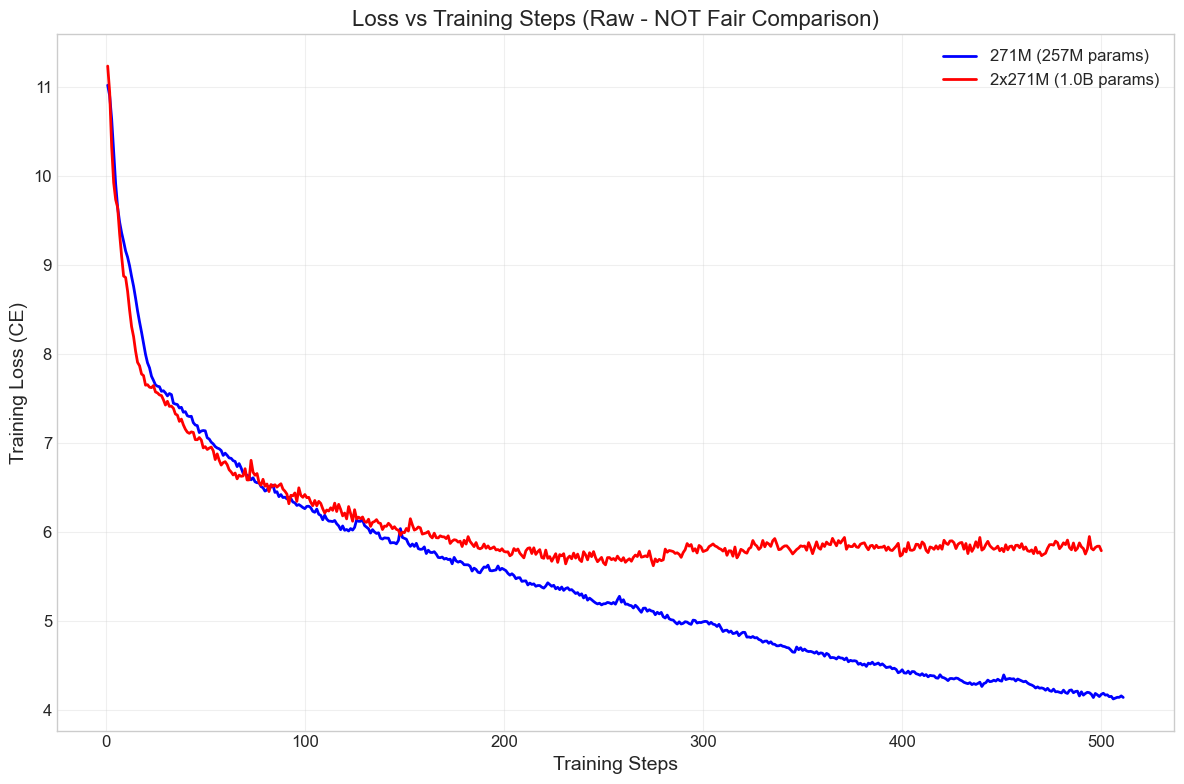


Note: This comparison is misleading because:
- 271M sees 1M tokens/step, 2x271M sees 256K tokens/step
- At step 500: 271M has seen 500M tokens, 2x271M has seen 125M tokens


In [4]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(df_271M['step'], df_271M['loss'], 
        label=f"271M ({CONFIG['271M']['params']/1e6:.0f}M params)",
        color=CONFIG['271M']['color'], linewidth=2)
ax.plot(df_2x271M['step'], df_2x271M['loss'],
        label=f"2x271M ({CONFIG['2x271M']['params']/1e9:.1f}B params)",
        color=CONFIG['2x271M']['color'], linewidth=2)

ax.set_xlabel('Training Steps', fontsize=14)
ax.set_ylabel('Training Loss (CE)', fontsize=14)
ax.set_title('Loss vs Training Steps (Raw - NOT Fair Comparison)', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nNote: This comparison is misleading because:")
print("- 271M sees 1M tokens/step, 2x271M sees 256K tokens/step")
print("- At step 500: 271M has seen 500M tokens, 2x271M has seen 125M tokens")

## Plot 2: Log-Log Scale (Steps)

As requested: `log(loss)` vs `log(steps)`

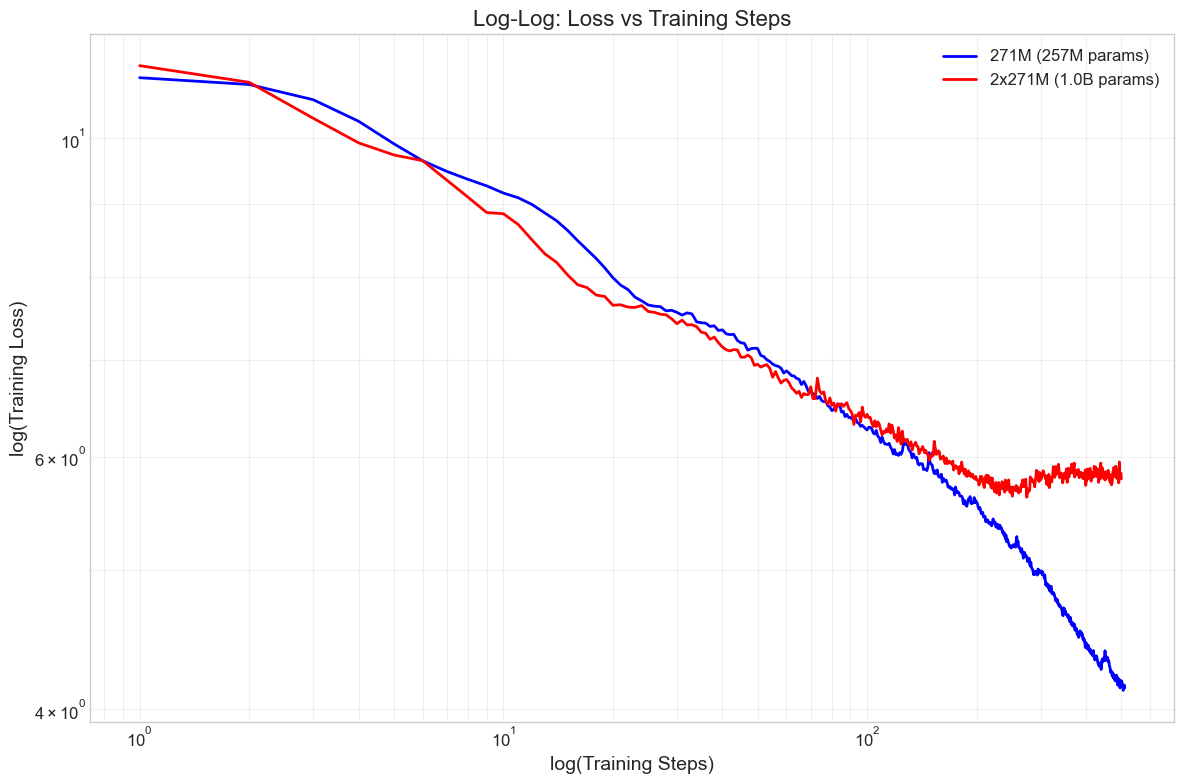

In [5]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.loglog(df_271M['step'], df_271M['loss'], 
          label=f"271M ({CONFIG['271M']['params']/1e6:.0f}M params)",
          color=CONFIG['271M']['color'], linewidth=2)
ax.loglog(df_2x271M['step'], df_2x271M['loss'],
          label=f"2x271M ({CONFIG['2x271M']['params']/1e9:.1f}B params)",
          color=CONFIG['2x271M']['color'], linewidth=2)

ax.set_xlabel('log(Training Steps)', fontsize=14)
ax.set_ylabel('log(Training Loss)', fontsize=14)
ax.set_title('Log-Log: Loss vs Training Steps', fontsize=16)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Plot 3: Tokens Seen (Fair Data Comparison)

**Transformation:** `x_normalized = steps × global_batch_size`

This normalizes by the total number of tokens the model has processed.

**Why this is useful:**
- Answers: "How much data has the model seen?"
- Standard metric for scaling law studies (Chinchilla, etc.)
- Larger models are typically more sample-efficient (need fewer tokens to reach same loss)

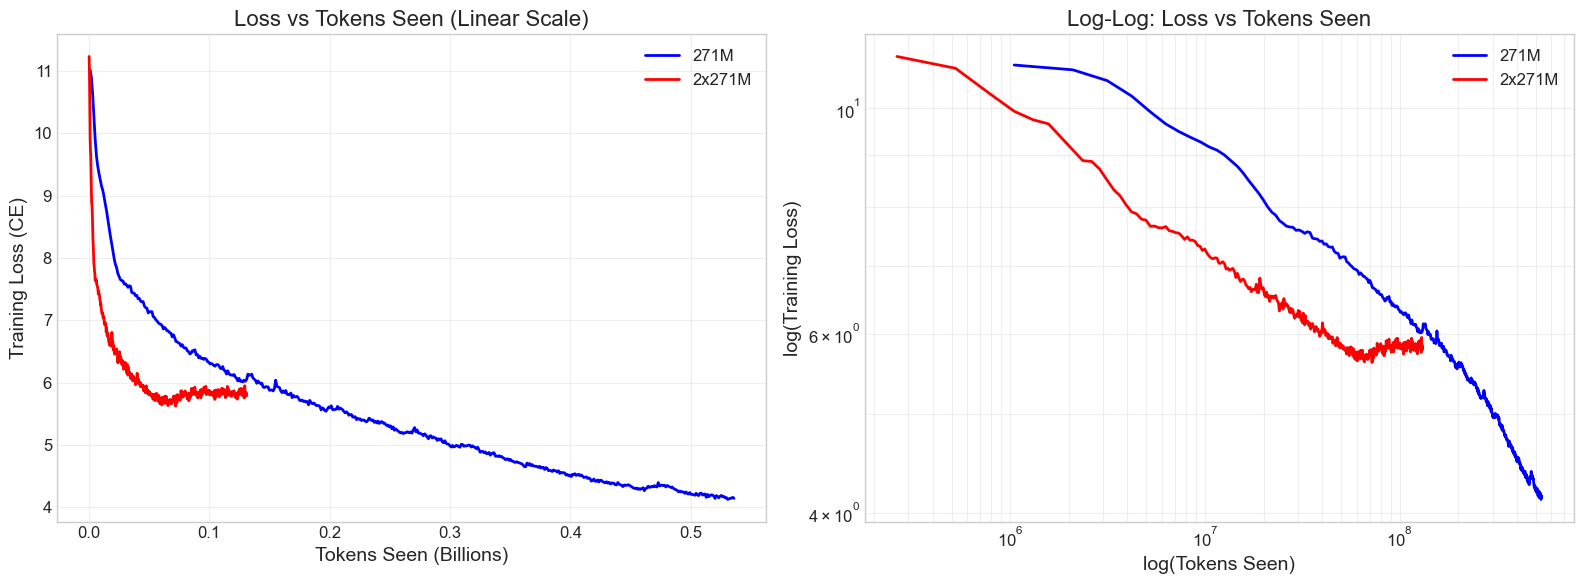


Calculation:
  tokens_seen = step × global_batch_size

271M at step 500: 0.52B tokens
2x271M at step 500: 0.13B tokens


In [6]:
# Calculate tokens seen for each model
tokens_271M = df_271M['step'] * CONFIG['271M']['global_batch_size']
tokens_2x271M = df_2x271M['step'] * CONFIG['2x271M']['global_batch_size']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale
ax1 = axes[0]
ax1.plot(tokens_271M / 1e9, df_271M['loss'], 
         label=f"271M", color=CONFIG['271M']['color'], linewidth=2)
ax1.plot(tokens_2x271M / 1e9, df_2x271M['loss'],
         label=f"2x271M", color=CONFIG['2x271M']['color'], linewidth=2)
ax1.set_xlabel('Tokens Seen (Billions)', fontsize=14)
ax1.set_ylabel('Training Loss (CE)', fontsize=14)
ax1.set_title('Loss vs Tokens Seen (Linear Scale)', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Log-Log scale
ax2 = axes[1]
ax2.loglog(tokens_271M, df_271M['loss'], 
           label=f"271M", color=CONFIG['271M']['color'], linewidth=2)
ax2.loglog(tokens_2x271M, df_2x271M['loss'],
           label=f"2x271M", color=CONFIG['2x271M']['color'], linewidth=2)
ax2.set_xlabel('log(Tokens Seen)', fontsize=14)
ax2.set_ylabel('log(Training Loss)', fontsize=14)
ax2.set_title('Log-Log: Loss vs Tokens Seen', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nCalculation:")
print("  tokens_seen = step × global_batch_size")
print(f"\n271M at step 500: {500 * CONFIG['271M']['global_batch_size'] / 1e9:.2f}B tokens")
print(f"2x271M at step 500: {500 * CONFIG['2x271M']['global_batch_size'] / 1e9:.2f}B tokens")

## Plot 4: FLOPs (Fair Compute Comparison)

**Transformation:** `x_normalized = steps × 6 × N × tokens_per_step`

Where:
- `6` is the approximate FLOP multiplier for transformers (forward + backward pass)
- `N` is the number of model parameters
- `tokens_per_step` is the global batch size

**Why this is useful:**
- Accounts for the fact that larger models do more compute per token
- Used in Chinchilla-style scaling law analysis
- Shows compute-optimal comparison

**Interesting observation:** Your two configs have ~similar FLOPs per step!
- 271M: 6 × 257M × 1M = 1.54e15 FLOPs/step
- 2x271M: 6 × 1B × 256K = 1.54e15 FLOPs/step

FLOPs per step:
  271M: 1.62e+15 FLOPs/step
  2x271M: 1.62e+15 FLOPs/step
  Ratio: 1.00x


/var/folders/rb/2shjjsn54_l40wwc54nxtdvm0000gn/T/ipykernel_32468/2396726485.py:41: UserWarning: Glyph 8312 (\N{SUPERSCRIPT EIGHT}) missing from font(s) Arial.
  plt.tight_layout()
/Users/timur/Desktop/Relace/wandb_analysis_venv/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8312 (\N{SUPERSCRIPT EIGHT}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


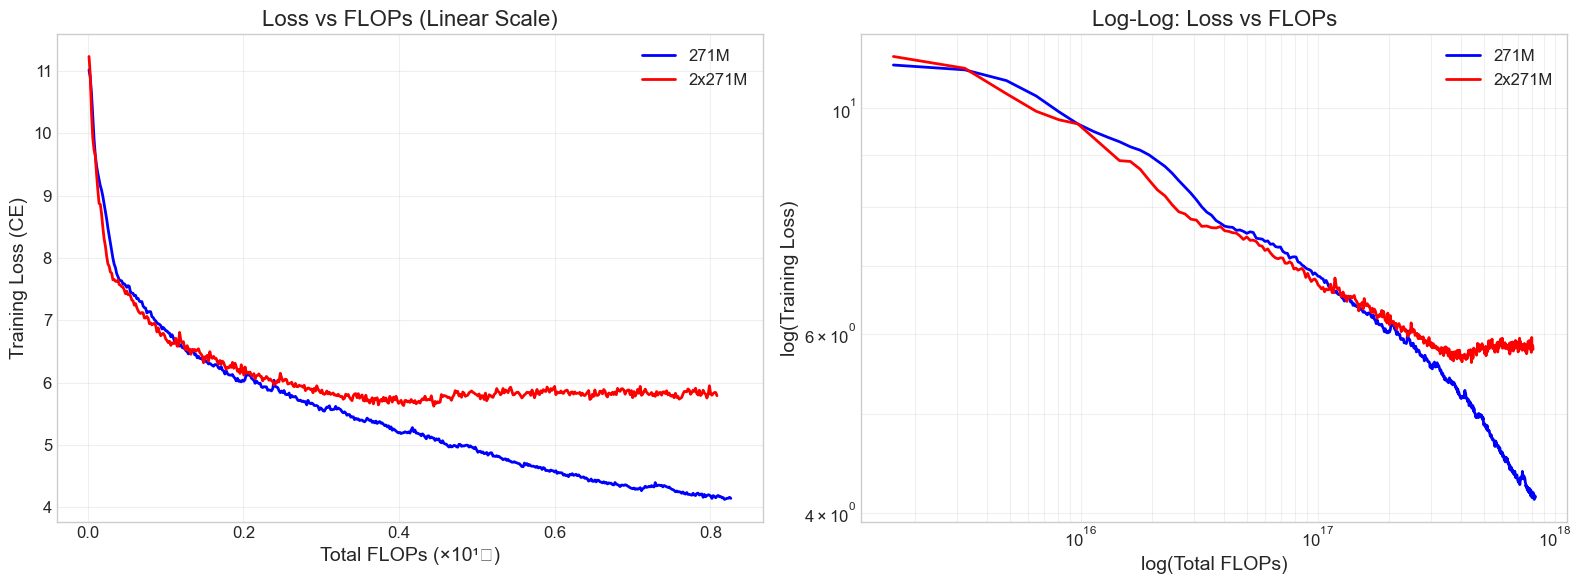


Calculation:
  total_flops = step × 6 × params × tokens_per_step


In [7]:
# Calculate FLOPs for each model
# FLOPs ≈ 6 × N × D where N=params, D=tokens
flops_271M = df_271M['step'] * 6 * CONFIG['271M']['params'] * CONFIG['271M']['global_batch_size']
flops_2x271M = df_2x271M['step'] * 6 * CONFIG['2x271M']['params'] * CONFIG['2x271M']['global_batch_size']

# FLOPs per step for comparison
flops_per_step_271M = 6 * CONFIG['271M']['params'] * CONFIG['271M']['global_batch_size']
flops_per_step_2x271M = 6 * CONFIG['2x271M']['params'] * CONFIG['2x271M']['global_batch_size']

print("FLOPs per step:")
print(f"  271M: {flops_per_step_271M:.2e} FLOPs/step")
print(f"  2x271M: {flops_per_step_2x271M:.2e} FLOPs/step")
print(f"  Ratio: {flops_per_step_2x271M/flops_per_step_271M:.2f}x")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear scale
ax1 = axes[0]
ax1.plot(flops_271M / 1e18, df_271M['loss'], 
         label=f"271M", color=CONFIG['271M']['color'], linewidth=2)
ax1.plot(flops_2x271M / 1e18, df_2x271M['loss'],
         label=f"2x271M", color=CONFIG['2x271M']['color'], linewidth=2)
ax1.set_xlabel('Total FLOPs (×10¹⁸)', fontsize=14)
ax1.set_ylabel('Training Loss (CE)', fontsize=14)
ax1.set_title('Loss vs FLOPs (Linear Scale)', fontsize=16)
ax1.legend(fontsize=12)
ax1.grid(True, alpha=0.3)

# Log-Log scale
ax2 = axes[1]
ax2.loglog(flops_271M, df_271M['loss'], 
           label=f"271M", color=CONFIG['271M']['color'], linewidth=2)
ax2.loglog(flops_2x271M, df_2x271M['loss'],
           label=f"2x271M", color=CONFIG['2x271M']['color'], linewidth=2)
ax2.set_xlabel('log(Total FLOPs)', fontsize=14)
ax2.set_ylabel('log(Training Loss)', fontsize=14)
ax2.set_title('Log-Log: Loss vs FLOPs', fontsize=16)
ax2.legend(fontsize=12)
ax2.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print("\nCalculation:")
print("  total_flops = step × 6 × params × tokens_per_step")

## Plot 5: All Comparisons Side-by-Side

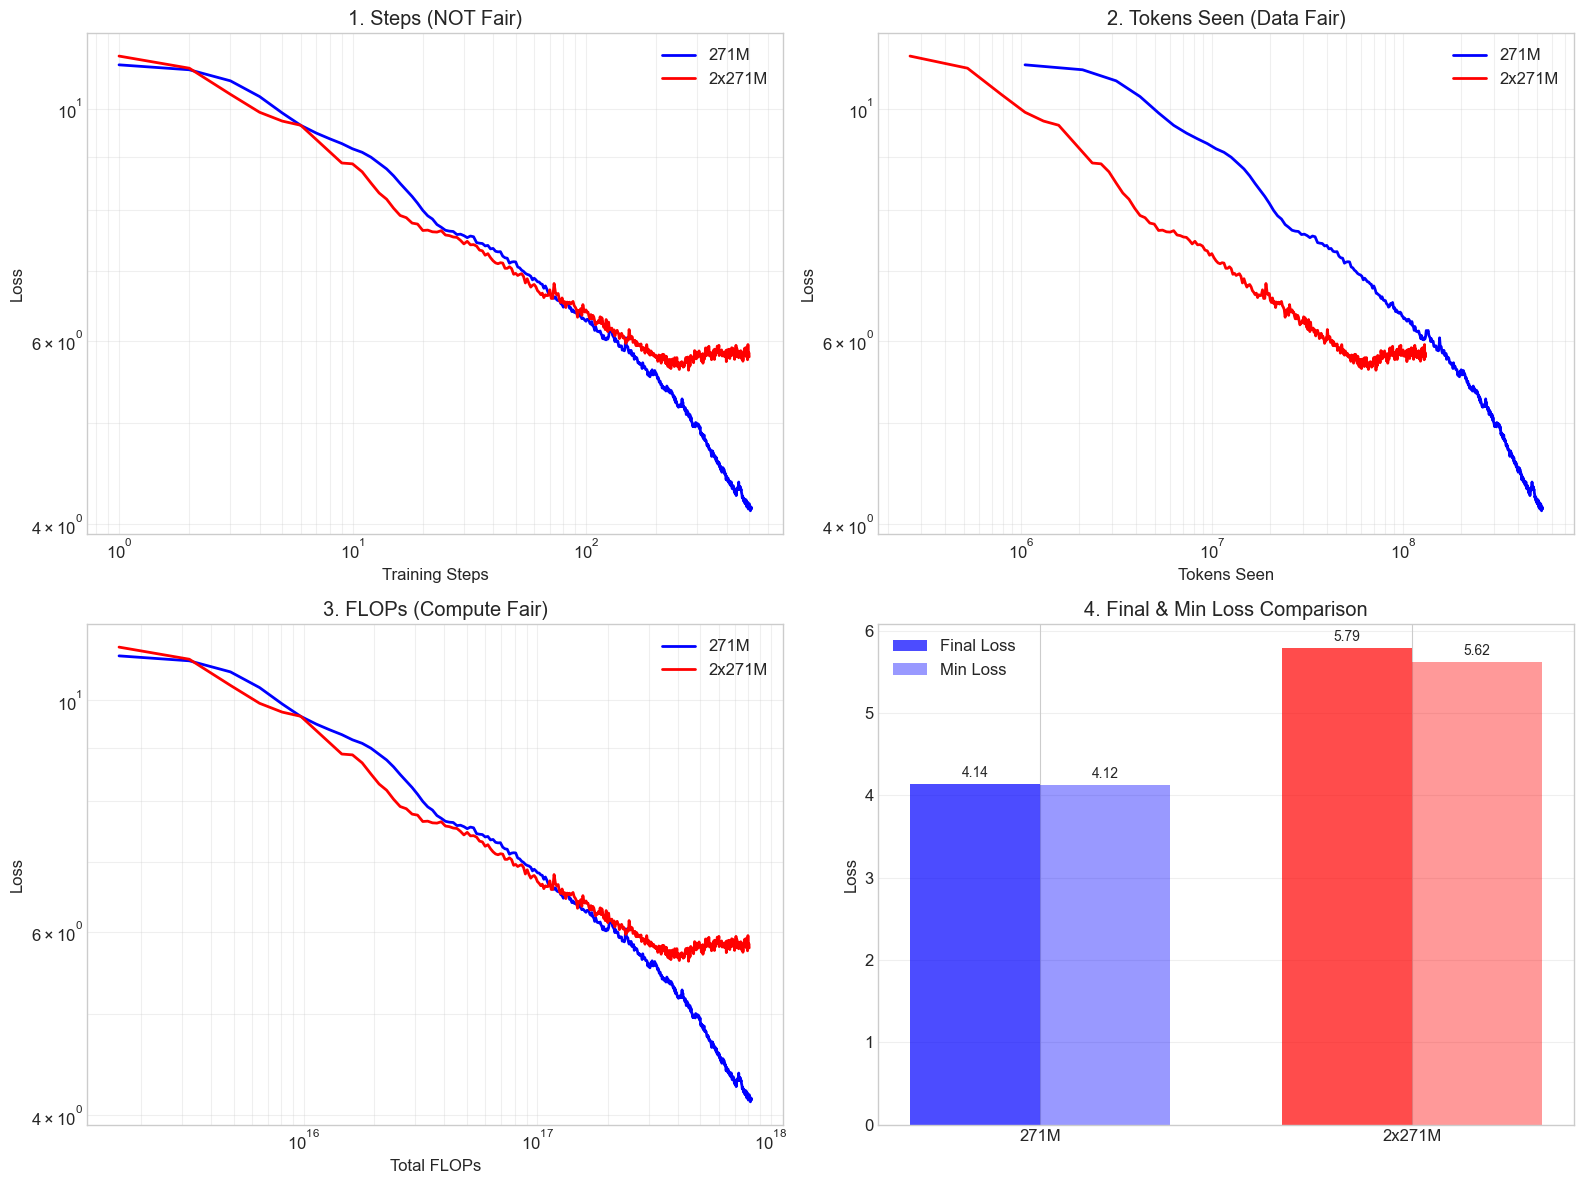


Figure saved to: /Users/timur/Desktop/Relace/scaling_comparison.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Steps (Log-Log)
ax = axes[0, 0]
ax.loglog(df_271M['step'], df_271M['loss'], label='271M', color='blue', linewidth=2)
ax.loglog(df_2x271M['step'], df_2x271M['loss'], label='2x271M', color='red', linewidth=2)
ax.set_xlabel('Training Steps')
ax.set_ylabel('Loss')
ax.set_title('1. Steps (NOT Fair)')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

# Plot 2: Tokens (Log-Log)
ax = axes[0, 1]
ax.loglog(tokens_271M, df_271M['loss'], label='271M', color='blue', linewidth=2)
ax.loglog(tokens_2x271M, df_2x271M['loss'], label='2x271M', color='red', linewidth=2)
ax.set_xlabel('Tokens Seen')
ax.set_ylabel('Loss')
ax.set_title('2. Tokens Seen (Data Fair)')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

# Plot 3: FLOPs (Log-Log)
ax = axes[1, 0]
ax.loglog(flops_271M, df_271M['loss'], label='271M', color='blue', linewidth=2)
ax.loglog(flops_2x271M, df_2x271M['loss'], label='2x271M', color='red', linewidth=2)
ax.set_xlabel('Total FLOPs')
ax.set_ylabel('Loss')
ax.set_title('3. FLOPs (Compute Fair)')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

# Plot 4: Final losses comparison
ax = axes[1, 1]
final_data = {
    '271M': {
        'final_loss': df_271M['loss'].iloc[-1],
        'min_loss': df_271M['loss'].min(),
        'tokens': tokens_271M.iloc[-1],
        'flops': flops_271M.iloc[-1]
    },
    '2x271M': {
        'final_loss': df_2x271M['loss'].iloc[-1],
        'min_loss': df_2x271M['loss'].min(),
        'tokens': tokens_2x271M.iloc[-1],
        'flops': flops_2x271M.iloc[-1]
    }
}

models = list(final_data.keys())
x_pos = np.arange(len(models))
width = 0.35

final_losses = [final_data[m]['final_loss'] for m in models]
min_losses = [final_data[m]['min_loss'] for m in models]

bars1 = ax.bar(x_pos - width/2, final_losses, width, label='Final Loss', color=['blue', 'red'], alpha=0.7)
bars2 = ax.bar(x_pos + width/2, min_losses, width, label='Min Loss', color=['blue', 'red'], alpha=0.4)

ax.set_ylabel('Loss')
ax.set_title('4. Final & Min Loss Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(models)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)
for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('/Users/timur/Desktop/Relace/scaling_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nFigure saved to: /Users/timur/Desktop/Relace/scaling_comparison.png")

## Summary Table

In [9]:
summary = pd.DataFrame({
    'Model': ['271M', '2x271M'],
    'Total Params': [f"{CONFIG['271M']['params']/1e6:.0f}M", f"{CONFIG['2x271M']['params']/1e9:.2f}B"],
    'Tokens/Step': [f"{CONFIG['271M']['global_batch_size']/1e6:.1f}M", f"{CONFIG['2x271M']['global_batch_size']/1e3:.0f}K"],
    'Final Step': [df_271M['step'].iloc[-1], df_2x271M['step'].iloc[-1]],
    'Total Tokens': [f"{tokens_271M.iloc[-1]/1e9:.2f}B", f"{tokens_2x271M.iloc[-1]/1e9:.2f}B"],
    'Total FLOPs': [f"{flops_271M.iloc[-1]:.2e}", f"{flops_2x271M.iloc[-1]:.2e}"],
    'Final Loss': [f"{df_271M['loss'].iloc[-1]:.3f}", f"{df_2x271M['loss'].iloc[-1]:.3f}"],
    'Min Loss': [f"{df_271M['loss'].min():.3f}", f"{df_2x271M['loss'].min():.3f}"]
})

print("\n" + "="*80)
print("SUMMARY")
print("="*80)
display(summary)


SUMMARY


,Model,Total Params,Tokens/Step,Final Step,Total Tokens,Total FLOPs,Final Loss,Min Loss
0,271M,257M,1.0M,511,0.54B,8.26e+17,4.139,4.122
1,2x271M,1.03B,262K,500,0.13B,8.08e+17,5.788,5.620


## Interpretation

### Key Findings:

1. **Raw Steps (Plot 1)**: The 2x271M model appears to saturate much earlier in terms of steps, but this is misleading because it sees fewer tokens per step.

2. **Tokens Seen (Plot 2)**: This is the **recommended comparison** for understanding sample efficiency. If 2x271M reaches lower loss with fewer tokens, it means the larger model is more sample-efficient.

3. **FLOPs (Plot 3)**: Interestingly, your configurations have nearly identical FLOPs per step, so the FLOPs comparison looks similar to the steps comparison.

### Transformation Formulas:

| X-Axis | Formula | What it measures |
|--------|---------|------------------|
| Steps | `step` | Raw training iterations |
| Tokens | `step × batch_size` | Data seen by model |
| FLOPs | `step × 6 × params × batch_size` | Total compute used |

### Recommendations:

- For **data efficiency**: Use **Tokens Seen**
- For **compute efficiency**: Use **FLOPs**
- For **Chinchilla-style analysis**: Use both, and look at loss vs tokens at fixed FLOPs